# Decomposition of ridges in the H2CO data

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import os
import sys
sys.path.append('../../../B5_NOEMA_30m')
from B5setup import *
import pyspeckit
from spectral_cube import SpectralCube
from astropy.wcs import WCS
from crispy import image_ridge_find, grid_ridge
from skimage.morphology import skeletonize_3d, skeletonize
import matplotlib.pyplot as plt
%matplotlib widget

## Creating a cube with only the fitted gaussians and fitting ridges to it


In [2]:
cubefile = '../B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected'
fitfile1Gtotalaic = cubefile[3:] + '_1G_fitparams_total_aicres.fits'
fitfile2Gtotalaic = cubefile[3:] + '_2G_fitparams_total_aicres.fits'
fitfile3Gtotalaic = cubefile[3:] + '_3G_fitparams_total_aicres.fits'
mask2dfile = cubefile + '_mask.fits'
simcubefile = cubefile[3:] + '_sim_thin.fits'
ridgetextfilename = 'ridge_coords.txt'
fitsfileridges = 'ridge_coords_cube.fits'
fitsfileridges_skel_crispy = 'skel_coords_cube_clean_grid_ppv.fits'
fitsfileridges_skel_skimage = 'skel_coords_cube_skeletonize_skimage.fits'

show_3dplots = False
show_2dplots = True

The original cube and header need to be loaded, as well as the original fit, however, only if we are constructing the ridges, we need to load the Gaussian fits

In [3]:
# here we create the cubes
cubenormal = SpectralCube.read(cubefile+'.fits')
cubehead = fits.getheader(cubefile+'.fits')
wcshead = WCS(cubehead)
mask2d = fits.getdata(mask2dfile)

In [4]:

spc1G = pyspeckit.Cube(cube=cubenormal, mask=mask2d)
spc2G = pyspeckit.Cube(cube=cubenormal, mask=mask2d)
spc3G = pyspeckit.Cube(cube=cubenormal, mask=mask2d)
spc1G.load_model_fit(fitfile1Gtotalaic, npars=3, npeaks=1, fittype='gaussian')
spc2G.load_model_fit(fitfile2Gtotalaic, npars=3, npeaks=2, fittype='gaussian')
spc3G.load_model_fit(fitfile3Gtotalaic, npars=3, npeaks=3, fittype='gaussian')
spc1G.parcube[2, :, :] = 0.08
spc2G.parcube[2, :, :] = 0.08
spc2G.parcube[5, :, :] = 0.08
spc3G.parcube[2, :, :] = 0.08
spc3G.parcube[5, :, :] = 0.08
spc3G.parcube[8, :, :] = 0.08


NaN or infinite values encountered in parameter cube.
Guesses have been changed from [nan, nan, nan] to [nan, nan, nan]
NaN or infinite values encountered in parameter cube.
Guesses have been changed from [nan, nan, nan, nan, nan, nan] to [nan, nan, nan, nan, nan, nan]
NaN or infinite values encountered in parameter cube.
Guesses have been changed from [nan, nan, nan, nan, nan, nan, nan, nan, nan] to [nan, nan, nan, nan, nan, nan, nan, nan, nan]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


In [5]:
if not os.path.exists(ridgetextfilename):
    # if the ridges do not exist, we do the calculation
    
    fittedmodel1G = spc1G.get_modelcube()
    fittedmodel2G = spc2G.get_modelcube()
    fittedmodel3G = spc3G.get_modelcube()
    cubecombined = np.nansum([fittedmodel1G, fittedmodel2G, fittedmodel3G], axis=0)
    if not os.path.exists(simcubefile): fits.writeto(simcubefile, cubecombined, cubehead)
    
    ridges_coords = image_ridge_find.run(simcubefile, eps=0.05, thres=4, ordXYZ=False, walkerThres=5)
    image_ridge_find.write_output(test_coords, ridgetextfilename)

else:
    cubecombined = fits.getdata(simcubefile)
    ridges_coords =  grid_ridge.read_table(ridgetextfilename)

In [6]:
if not os.path.exists(fitsfileridges):
    
    ridges_cube = np.zeros(np.shape(cubenormal.unmasked_data[:,:,:]))
    
    indexes = np.round(ridges_coords).astype(int)
    for index in indexes:
        indexcor = np.transpose(index)[0]
        ridges_cube[indexcor[0], indexcor[1], indexcor[2]] = 1
    
    fits.writeto(fitsfileridges, ridges_cube, cubehead)
else:
    ridges_cube = fits.getdata(fitsfileridges)

In [7]:
index_ridges = np.flip(np.where(ridges_cube > 0), axis=0)
wcs_ridges = np.transpose(wcshead.all_pix2world(np.transpose(index_ridges), 0))

if show_3dplots:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111,projection='3d')

    ax.scatter(wcs_ridges[0], wcs_ridges[1], wcs_ridges[2], alpha=0.3)
    ax.set_xlabel('ra')
    ax.set_ylabel('dec')
    ax.set_zlabel('v')

We are finding a very interesting separation: the algorithm, even if designed to find ridges/skeletons/spines, it can also be used to group structures more clearly. When we consider only the central velocity of the fits (by forcing the analyzed cube to hae Gaussians of $\sigma_v= 0.08$ km/s) there are two clear groups of peaks, one to the north, one to the south.

Now, let us search for the best way to obtain a fiducial streamline from this.

## Finding the skeleton and the spine in the ridges

We follow the procedure in Chen+2020. What we can do is then sum up all channels and find a skeleton there.

In [8]:
if not os.path.exists(fitsfileridges_skel_crispy):
    skeleton_cube_crispy = grid_ridge.clean_grid_ppv(ridge_coords, cubecombined)
    grid_ridge.write_skel(fitsfileridges_skel_crispy, skeleton_cube_crispy, cubehead)
else:
    skeleton_cube_crispy = fits.getdata(fitsfileridges_skel_crispy)

In [9]:
index_skel = np.flip(np.where(skeleton_cube_crispy > 0), axis=0)
wcs_skel = np.transpose(wcshead.all_pix2world(np.transpose(index_skel), 0))

if show_3dplots:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111,projection='3d')

    ax.scatter(wcs_skel[0], wcs_skel[1], wcs_skel[2], alpha=0.3)
    ax.set_xlabel('ra')
    ax.set_ylabel('dec')
    ax.set_zlabel('v')

In [10]:
if not os.path.exists(fitsfileridges_skel_skimage):
    skeleton_cube_skimage = skeletonize_3d(ridges_cube)
    grid_ridge.write_skel(fitsfileridges_skel_skimage, skeleton_cube_skimage, cubehead)
else:
    skeleton_cube_skimage = fits.getdata(fitsfileridges_skel_skimage)

In [11]:
index_skel_skimage = np.flip(np.where(skeleton_cube_skimage > 0), axis=0)
wcs_skel_skimage = np.transpose(wcshead.all_pix2world(np.transpose(index_skel_skimage), 0))

if show_3dplots:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111,projection='3d')

    ax.scatter(wcs_skel_skimage[0], wcs_skel_skimage[1], wcs_skel_skimage[2], alpha=0.3)
    ax.set_xlabel('ra')
    ax.set_ylabel('dec')
    ax.set_zlabel('v')

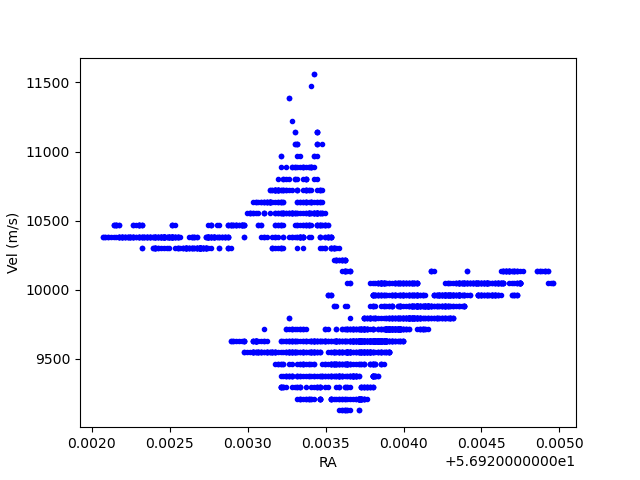

In [12]:
if show_2dplots:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(wcs_ridges[0], wcs_ridges[2], 'b.')
    ax.set_xlabel('RA')
    ax.set_ylabel('Vel (m/s)')


What if we separate the ridges first and then skeletonize in 2d?


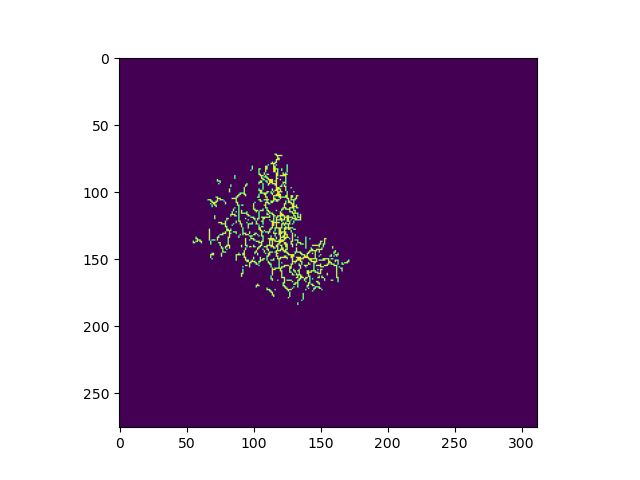

In [13]:
index_ridges_cube_mask_max = np.amax(np.where(cubenormal.spectral_axis > 10.17*u.km/u.s))
ridges_cube_blue = ridges_cube[index_ridges_cube_mask_max:, :, :]
ridges_image_blue = np.sum(ridges_cube_blue, axis=0)
ridges_image_blue[np.where(ridges_image_blue>0)] = 1
ridges_blue_coords = np.array(np.where(ridges_image_blue>0))
if show_2dplots:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(ridges_image_blue)

---gridding 92 distinct skeletons---


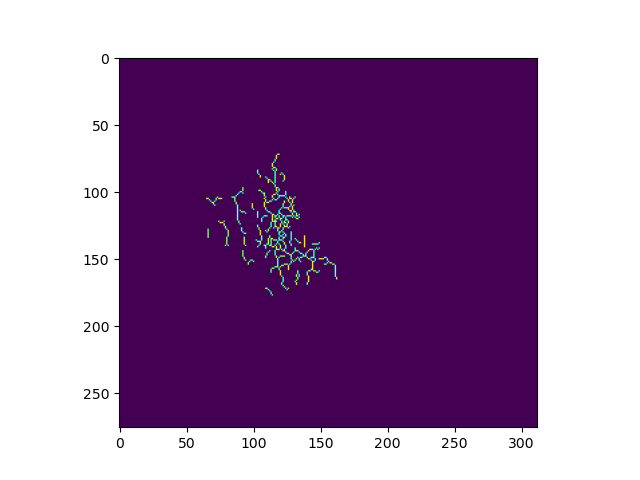

In [14]:
# now we skeletonize the image
skel_image_blue_crispy = grid_ridge.clean_grid(ridges_blue_coords, ridges_image_blue)
if show_2dplots:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(skel_image_blue_crispy)

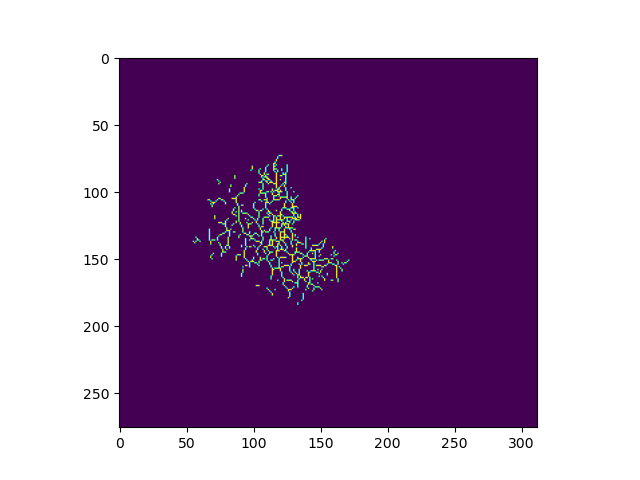

In [17]:
skel_image_blue_skimage = skeletonize(ridges_image_blue)
if show_2dplots:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(skel_image_blue_skimage)

In [ ]:
# fitsfileridges_skel2 = 'test_coords_cube_grid_function_clean_grid.fits'
# if not os.path.exists(fitsfileridges_skel2):
#     skeleton_cube2 = grid_ridge.clean_grid(test_coords, cubecombined)
#     grid_ridge.write_skel(fitsfileridges_skel2, skeleton_cube2, cubehead)

## Separating the ridges using PCA

We use PCA to determine if there is a simple criteria to use to separate the blueshifted and redshifted envelope

In [ ]:
# from sklearn.preprocessing import StandardScaler

In [ ]:
# for the analysis, fit_transform needs the shape (n_samples, n_features) and wcs_ridges is (nfeats, n_samples) for the plot
# wcs_ridges = np.transpose(wcs_ridges)

In [ ]:
# scaler = StandardScaler()
# scaled_wcs_ridges = scaler.fit_transform(wcs_ridges)

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# principalcomponents = pca.fit_transform(scaled_wcs_ridges)

In [ ]:
# principalcomponents[:,0]


In [ ]:
# fig = plt.figure(figsize = (6,6))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.scatter(principalcomponents[:,0], principalcomponents[:,1], alpha=0.5)

There could be a simple line in PCA space, but then we need to translate it back to ppv space. This can be work for later, for now just use the most blueshifted components to acknowledge